![CC](https://i.creativecommons.org/l/by/4.0/88x31.png)

This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

# Multivariate singular spectrum analysis (MSSA)

This notebook demonstrates and compares noise reduction via MSSA, PMSSA, and classical SVD. Specifically, reference data of the flow past a cylinder is first corrupted heavily with noise and then pre-processed/cleaned.

## Preparing the data

The dataset is taken from the flowTorch dataset collection. The noise is scaled with the absolute value of the vorticity to make the corruption more challenging.

In [1]:
from collections import defaultdict
from math import ceil
import torch as pt
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from flowtorch import DATASETS
from flowtorch.data import FOAMDataloader, mask_box
from flowtorch.analysis import SVD, MSSA, PMSSA

plt.rcParams["figure.dpi"] = 160

def set_seed(seed):
    pt.manual_seed(seed)
    np.random.seed(seed)

In [2]:
path = DATASETS["of_cylinder2D_binary"]
loader = FOAMDataloader(path)
times = [t for t in loader.write_times if float(t) >= 4.0]
vertices = loader.vertices[:, :2]
mask = mask_box(vertices, lower=[0.1, -1], upper=[0.75, 1])
data_matrix = pt.zeros((mask.sum().item(), len(times)), dtype=pt.float32)
for i, time in enumerate(times):
    # load the vorticity vector field, take the z-component [:, 2], and apply the mask
    data_matrix[:, i] = pt.masked_select(loader.load_snapshot("vorticity", time)[:, 2], mask)
data_matrix -= data_matrix.mean(dim=1).unsqueeze(-1)

Could not find precomputed cell centers and volumes.
Computing cell geometry from scratch (slow, not recommended for large meshes).
To compute cell centers and volumes in OpenFOAM, run:

postProcess -func "writeCellCentres" -constant -time none
postProcess -func "writeCellVolumes" -constant -time none


In [3]:
def apply_noise(dm, gamma = 0.0):
    dm_noisy = dm.clone()
    rows, cols = dm.shape
    for col in range(cols):
        dm_noisy[:, col] += (pt.rand(rows) - 0.5) * 2.0 * gamma * dm[:, col].abs()
    return dm_noisy

In [4]:
x = pt.masked_select(vertices[:, 0], mask)
y = pt.masked_select(vertices[:, 1], mask)

def add_contour(ax, field, vmax):
    levels = pt.linspace(-vmax, vmax, 120)
    ax.tricontourf(x, y, field, levels=levels, vmin=-vmax, vmax=vmax, cmap="seismic", extend="both")
    ax.add_patch(plt.Circle((0.2, 0.2), 0.05, color='k'))
    ax.set_aspect("equal", 'box')
    ax.set_xticklabels([])
    ax.set_yticklabels([])

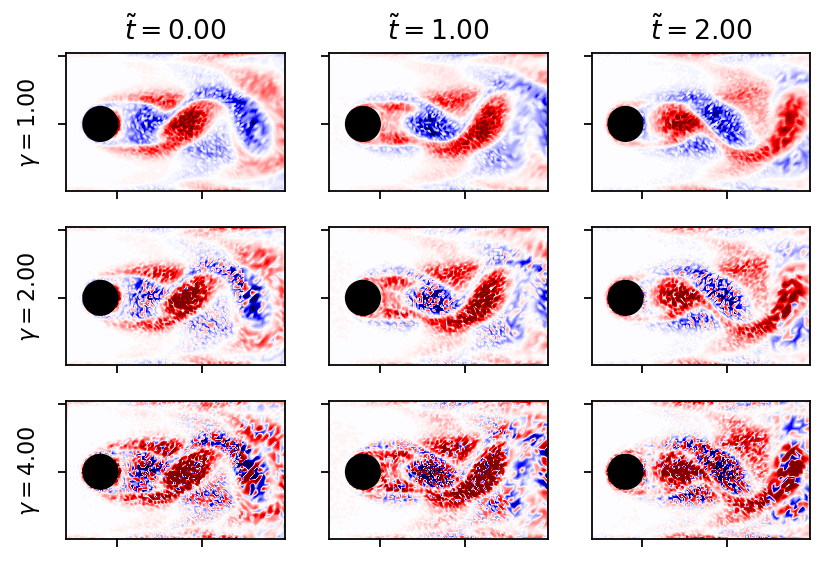

In [5]:
noise_levels_plot = (1.0, 2.0, 4.0)
fig, axarr = plt.subplots(len(noise_levels_plot), 3, figsize=(6, 4), sharex=True, sharey=True)

U_IN = 1.0
L = 0.1

for row, gamma in enumerate(noise_levels_plot):
    set_seed(row)
    dm_noisy = apply_noise(data_matrix, gamma)
    for col, i in enumerate((0, 4, 8)):
        add_contour(axarr[row, col], dm_noisy[:, i], data_matrix.max())
        if row == 0:
            axarr[row, col].set_title(r"$\tilde{t}=" + r"{:1.2f}$".format((float(times[i]) - float(times[0]))*U_IN/L))
    axarr[row, 0].set_ylabel(r"$\gamma = {:1.2f}$".format(gamma))
plt.show()

## Comparison of SVD, MSSA, and PMSSA

First, we clean the data using one of the aforementioned methods, and then we analyze the right singular vectors as in the work by [Ohmichi et al. (2022)](https://arxiv.org/abs/2203.07574). The truncation rank is kept constant to make the results comparable. To determine a suitable truncation rank for more challenging datasets, it is advisable to test different values against holdout data (train-validation-split). In practice, the automatically chosen rank (singular value hard thresholding) works well, too.

In [6]:
set_seed(0)
dm_noisy = apply_noise(data_matrix, 4.0)

In [7]:
svd_ref = SVD(data_matrix)
print(svd_ref)

SVD of a 7190x241 data matrix
Selected/optimal rank: 97/97
data type: torch.float32 (4b)
truncated SVD size: 2.7500Mb


In [8]:
svd_noisy = SVD(dm_noisy, rank=11)
dm_svd = svd_noisy.reconstruct()
print(svd_noisy)

SVD of a 7190x241 data matrix
Selected/optimal rank: 11/7
data type: torch.float32 (4b)
truncated SVD size: 319.3438Kb


In [9]:
mssa = MSSA(dm_noisy, rank=11)
dm_mssa = mssa.reconstruction
svd_mssa = SVD(dm_mssa, rank=11)
print(svd_mssa)

SVD of a 7190x241 data matrix
Selected/optimal rank: 11/114
data type: torch.float32 (4b)
truncated SVD size: 319.3438Kb


In [10]:
pmssa = PMSSA(dm_noisy, rank=11)
dm_pmssa = pmssa.reconstruction
svd_pmssa = SVD(dm_pmssa, rank=11)
print(svd_pmssa)

SVD of a 7190x241 data matrix
Selected/optimal rank: 11/12
data type: torch.float32 (4b)
truncated SVD size: 319.3438Kb


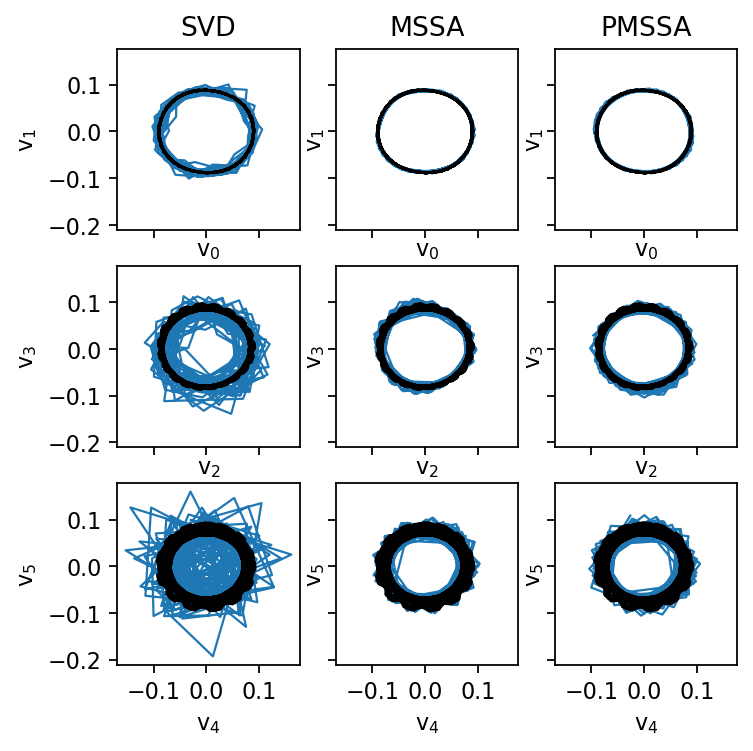

In [11]:
fig, axarr = plt.subplots(3, 3, figsize=(5, 5), sharex=True, sharey=True)

for i, svd in enumerate((svd_noisy, svd_mssa, svd_pmssa)):
    for j in range(3):
        axarr[j, i].plot(svd.V[:, 2*j], svd.V[:, 2*j+1], c="C0", ls="-", lw=1.0)
        axarr[j, i].plot(svd_ref.V[:, 2*j], svd_ref.V[:, 2*j+1], c="k", ls="-", lw=1.0)
    
axarr[0, 0].set_title("SVD")
axarr[0, 1].set_title("MSSA")
axarr[0, 2].set_title("PMSSA")
for i in range(3):
    for j in range(3):
        axarr[i, j].set_xlabel(rf"$\mathrm{{v}}_{2*i:d}$")
        axarr[i, j].set_ylabel(rf"$\mathrm{{v}}_{2*i+1:d}$")
plt.show()

In a typical SVD analysis, one would also compute the spectra of selected mode coefficients. Both MSSA and PMSSA significantly reduce the noise in the data and improve the clarity of the resulting spectra.

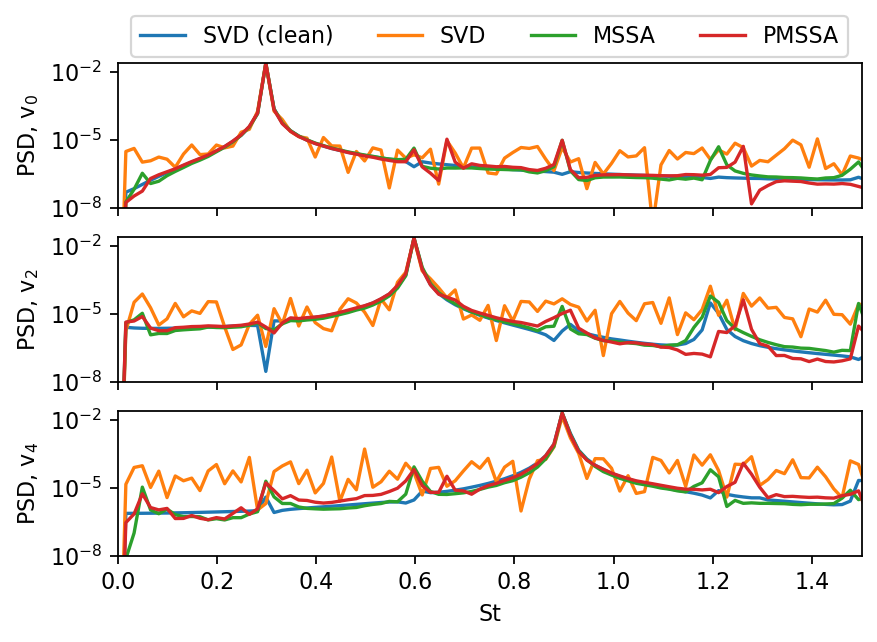

In [12]:
fig, axarr = plt.subplots(3, figsize=(6, 4), sharex=True, sharey=True)

fs = 1.0 / (float(times[1]) - float(times[0]))
labels = ("SVD (clean)", "SVD", "MSSA", "PMSSA")
for i, svd in enumerate((svd_ref, svd_noisy, svd_mssa, svd_pmssa)):
    for j in range(3):
        f, a = welch(svd.V[:, 2*j], fs, nperseg=len(times), window="boxcar")
        if j==0:
            axarr[j].plot(f*L/U_IN, a, c=f"C{i}", label=labels[i])
        else:
            axarr[j].plot(f*L/U_IN, a, c=f"C{i}")
        
axarr[0].legend(ncol=len(labels), loc="upper center", bbox_to_anchor=(0.5, 1.4))
axarr[0].set_xlim(0, 1.5)
axarr[0].set_ylim(1e-8)
axarr[-1].set_xlabel("St")
for j, ax in enumerate(axarr.flatten()):
    ax.set_yscale("log")
    ax.set_ylabel(rf"PSD, $\mathrm{{v}}_{j*2:d}$")
plt.show()

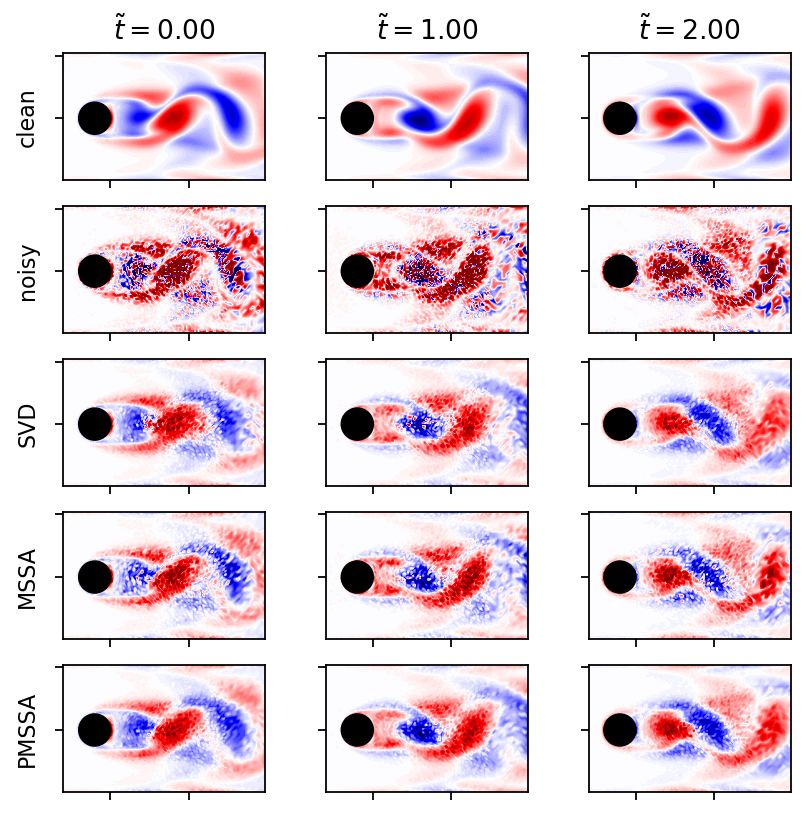

In [13]:
fig, axarr = plt.subplots(5, 3, figsize=(6, 6), sharex=True, sharey=True)

labels = ("clean", "noisy", "SVD", "MSSA", "PMSSA")
for row, dm in enumerate((data_matrix, dm_noisy, dm_svd, dm_mssa, dm_pmssa)):
    for col, i in enumerate((0, 4, 8)):
        add_contour(axarr[row, col], dm[:, i], data_matrix.max())
        if row == 0:
            axarr[row, col].set_title(r"$\tilde{t}=" + r"{:1.2f}$".format((float(times[i]) - float(times[0]))*U_IN/L))
    axarr[row, 0].set_ylabel(labels[row])
plt.show()

## Influence of hyperparameters

The two parameters of MSSA are the truncation rank and the number of time delays. The following parameter variation shows that a wide range of both parameters leads to reasonable results. Interestingly, computing the error norm against the clean and noisy reference datasets leads to opposite trends. Consequently, the reconstruction error itself is not a suitable indicator to chose the truncation parameter (unless the true data is known, which is usually not the case).

In [14]:
ranks = (1, 2, 4, 8, 16, 32, 64)
window_size = range(int(len(times)*0.05), int(len(times)*0.95), 5)
norm_clean = data_matrix.norm().item()
norm_noisy = dm_noisy.norm().item()
results = defaultdict(list)
count = 0
for r in ranks:
    for s in window_size:
        count += 1
        print(f"\r Running test {count:3d}/{len(ranks)*len(window_size):3d}", end="")
        dm = PMSSA(dm_noisy, s, r).reconstruction
        results[f"r{r}_clean"].append((dm - data_matrix).norm().item() / norm_clean)
        results[f"r{r}_noisy"].append((dm - dm_noisy).norm().item() / norm_noisy)

 Running test 308/308

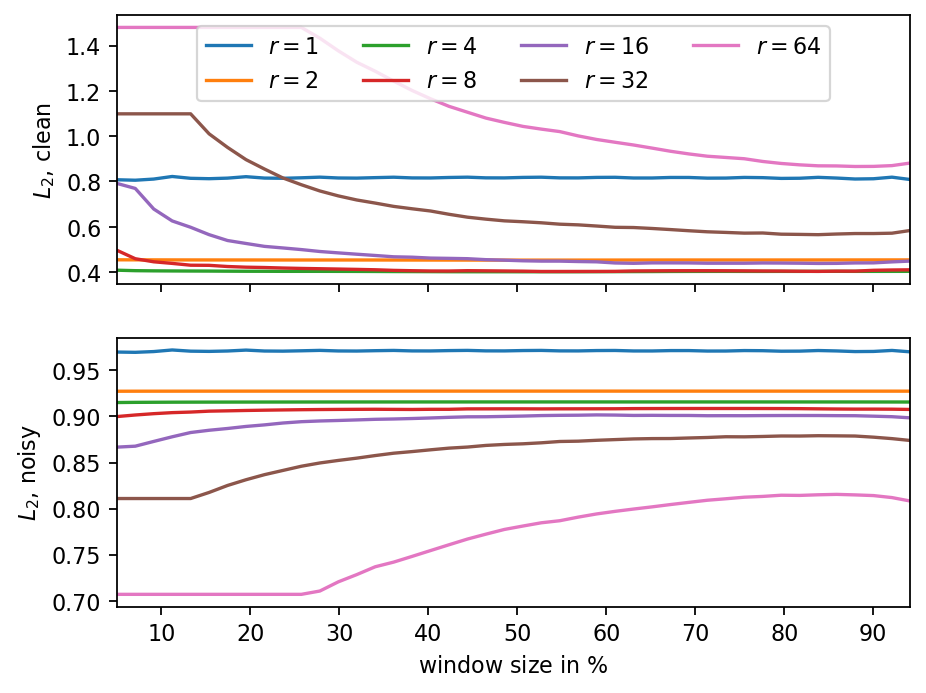

In [15]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)

ws_rel = [ws/len(times)*100 for ws in window_size]
for i, r in enumerate(ranks):
    ax1.plot(ws_rel, results[f"r{r}_clean"], c=f"C{i}", label=rf"$r={r:d}$")
    ax2.plot(ws_rel, results[f"r{r}_noisy"], c=f"C{i}")
    
ax2.set_xlabel("window size in $\%$")
ax1.set_ylabel(r"$L_2$, clean")
ax2.set_ylabel(r"$L_2$, noisy")
ax1.legend(ncol=ceil(len(ranks) / 2), bbox_to_anchor=(0.5, 1.0), loc="upper center")
ax1.set_xlim(ws_rel[0], ws_rel[-1])
plt.show()